In [12]:
import pandas as pd
# Load the dictionary from a pickle file
path = './IR_v09_df_trimmed_500_points.parquet'
df = pd.read_parquet(path)

In [13]:
df.keys()

Index(['NIST_molecule', 'CAS_NO', 'Name', 'molform', 'x', 'y'], dtype='object')

In [3]:
# Now let's add some things to try to predict from the IR data
## Predict presence or absence of functional groups - multi-label classification
## Predict full adjacency matrix from FTIR data - how close can you get to the full structure alone/with UV data
## Predict IR spectrum from molecular structure
## Predict smiles string using LSTM encoder with Seq2Seq in TensorFlow

In [14]:
df['CAS_NO']

0        2393-97-7
1        4214-79-3
2         107-21-1
3          78-69-3
4       74962-98-4
           ...    
5695      836-41-9
5696    13130-19-3
5697     6935-27-9
5698     1795-96-6
5699    19150-21-1
Name: CAS_NO, Length: 5700, dtype: object

In [15]:
#Start with item 250 - CAS_NO 1705-85-7 as an example, then try item 551 - CAS_NO 30711-40-1
import pubchempy
item = df['CAS_NO'][250]
print(item)

# Fetch SMILES string from PubChem
pubchem_compound = pubchempy.get_compounds(item, 'name')
smile = pubchem_compound[0].canonical_smiles
print(smile)

2043-61-0
C1CCC(CC1)C=O


In [16]:
## Rename df to be CompoundData and then add to compounddata, then add columns for whether the functional groups exist in each molecule

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw

#SMARTS patterns: https://daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html
AllenicPatt = Chem.MolFromSmarts('[$([CX2](=C)=C)]')
VinylicPatt = Chem.MolFromSmarts('[$([CX3]=[CX3])]')
ArenePatt = Chem.MolFromSmarts('c')
AlcoholPatt = Chem.MolFromSmarts('[#6][OX2H]')
EtherPatt = Chem.MolFromSmarts('[OD2]([#6])[#6]')
AminePatt = Chem.MolFromSmarts('[NX3;H2,H1;!$(NC=O)]')
IminePatt = Chem.MolFromSmarts('[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]')
NitrilePatt = Chem.MolFromSmarts('[NX1]#[CX2]')
ThiolPatt = Chem.MolFromSmarts('[#16X2H]')
SulfidePatt = Chem.MolFromSmarts('[SX2;!#16X2H]')
DisulfidePatt = Chem.MolFromSmarts('[#16X2H0;!#16X2H]')
AldehydePatt = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
KetonePatt = Chem.MolFromSmarts('[#6][CX3](=O)[#6]')
CarboxylAcidPatt = Chem.MolFromSmarts('[OX2H][CX3]=[OX1]')
EsterPatt = Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]')
ThioesterPatt = Chem.MolFromSmarts('S([#6])[CX3](=O)[#6]')
AmidePatt = Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]')
AcidChloridePatt = Chem.MolFromSmarts('[CX3](=[OX1])[F,Cl,Br,I]')
AnhydridePatt = Chem.MolFromSmarts('[CX3](=[OX1])[OX2][CX3](=[OX1])')

In [18]:
#comment this line line and execute to process functional groups - note this code takes >15 minutes to run
import pubchempy
from rdkit import Chem
from tqdm.notebook import tqdm  # Jupyter-friendly progress bar

# Initialize the functional group columns
df['smiles'] = ''
df['Allenic'] = 0
df['Vinylic'] = 0
df['Arene'] = 0
df['Alcohol'] = 0
df['Ether'] = 0
df['Amine'] = 0
df['Imine'] = 0
df['Nitrile'] = 0
df['Thiol'] = 0
df['Sulfide'] = 0
df['Disulfide'] = 0
df['Aldehyde'] = 0
df['Ketone'] = 0
df['CarboxylAcid'] = 0
df['Ester'] = 0
df['Thioester'] = 0
df['Amide'] = 0
df['AcidChloride'] = 0
df['Anhydride'] = 0
df['Errors'] = 0

# Initialize an error counter
error_count = 0

# Use tqdm to track progress with a live error counter in the status bar
with tqdm(total=len(df), desc="Processing Molecules", unit="molecule") as pbar:
    for index, row in df.iterrows():

        try:
            # Retrieve the compound from PubChem and get its SMILES
            pubchem_compound = pubchempy.get_compounds(df.at[index, 'CAS_NO'], 'name')
            smiles = pubchem_compound[0].canonical_smiles
            mol = Chem.MolFromSmiles(smiles)
            df.at[index, 'smiles'] = smiles  # Store the SMILES in the DataFrame

        except Exception as e:
            df.at[index, 'Errors'] = 1
            error_count += 1  # Increment the error counter
            pbar.set_postfix({'Errors': error_count})  # Update error count in the status bar

        try:
            # Assign functional groups
            df.loc[index, 'Allenic'] = 1 if mol.HasSubstructMatch(AllenicPatt) else 0
            df.loc[index, 'Vinylic'] = 1 if mol.HasSubstructMatch(VinylicPatt) else 0
            df.loc[index, 'Arene'] = 1 if mol.HasSubstructMatch(ArenePatt) else 0
            df.loc[index, 'Alcohol'] = 1 if mol.HasSubstructMatch(AlcoholPatt) else 0
            df.loc[index, 'Ether'] = 1 if mol.HasSubstructMatch(EtherPatt) else 0
            df.loc[index, 'Amine'] = 1 if mol.HasSubstructMatch(AminePatt) else 0
            df.loc[index, 'Imine'] = 1 if mol.HasSubstructMatch(IminePatt) else 0
            df.loc[index, 'Nitrile'] = 1 if mol.HasSubstructMatch(NitrilePatt) else 0
            df.loc[index, 'Thiol'] = 1 if mol.HasSubstructMatch(ThiolPatt) else 0
            df.loc[index, 'Sulfide'] = 1 if mol.HasSubstructMatch(SulfidePatt) else 0
            df.loc[index, 'Disulfide'] = 1 if mol.HasSubstructMatch(DisulfidePatt) else 0
            df.loc[index, 'Aldehyde'] = 1 if mol.HasSubstructMatch(AldehydePatt) else 0
            df.loc[index, 'Ketone'] = 1 if mol.HasSubstructMatch(KetonePatt) else 0
            df.loc[index, 'CarboxylAcid'] = 1 if mol.HasSubstructMatch(CarboxylAcidPatt) else 0
            df.loc[index, 'Ester'] = 1 if mol.HasSubstructMatch(EsterPatt) else 0
            df.loc[index, 'Thioester'] = 1 if mol.HasSubstructMatch(ThioesterPatt) else 0
            df.loc[index, 'Amide'] = 1 if mol.HasSubstructMatch(AmidePatt) else 0
            df.loc[index, 'AcidChloride'] = 1 if mol.HasSubstructMatch(AcidChloridePatt) else 0
            df.loc[index, 'Anhydride'] = 1 if mol.HasSubstructMatch(AnhydridePatt) else 0

        except Exception as e:
            df.at[index, 'Errors'] = 1
            error_count += 1  # Increment the error counter
            pbar.set_postfix({'Errors': error_count})  # Update error count in the status bar

        # Update the progress bar
        pbar.update(1)

# Display the final DataFrame
display(df)


Processing Molecules:   0%|          | 0/5700 [00:00<?, ?molecule/s]

,NIST_molecule,CAS_NO,Name,molform,x,y,smiles,Allenic,Vinylic,Arene,...,Disulfide,Aldehyde,Ketone,CarboxylAcid,Ester,Thioester,Amide,AcidChloride,Anhydride,Errors
0,C2393977,2393-97-7,Bis(4-chlorophenylthio)methane,C 13 H 10 Cl 2 S 2,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.013517509083288972, 0.014031092815933097, 0...",C1=CC(=CC=C1SCSC2=CC=C(C=C2)Cl)Cl,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,C4214793,4214-79-3,5-Chloro-2-hydroxypyridine,C 5 H 4 Cl N O,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.013896954532491117, 0.017858277293168977, 0...",C1=CC(=O)NC=C1Cl,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,C107211,107-21-1,"1,2-Ethanediol",C 2 H 6 O 2,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.025715587789266203, 0.021829493761547816, 0...",C(CO)O,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C78693,78-69-3,"3,7-Dimethyl-3-octanol",C 10 H 22 O,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.005221425575585162, 0.005823949408950356, 0...",CCC(C)(CCCC(C)C)O,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C74962984,74962-98-4,trans-2-Tridecen-1-ol,C 13 H 26 O,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.0006111964679303738, 0.0008712045717495148,...",CCCCCCCCCCC=CCO,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,C836419,836-41-9,N-(4-Methoxybenzylidene)aniline,C 14 H 13 N O,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.018739289555755784, 0.03201720773809309, 0....",COC1=CC=C(C=C1)C=NC2=CC=CC=C2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5696,C13130193,13130-19-3,"1,2,3,4-Tetrahydrodibenzofuran",C 12 H 12 O,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.02457619758333708, 0.01243393029431028, 0.0...",C1CCC2=C(C1)C3=CC=CC=C3O2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5697,C6935279,6935-27-9,2-Benzylaminopyridine 90-180um,C 12 H 12 N 2,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.06037169222775295, 0.0511317628044184, 0.02...",C1=CC=C(C=C1)CNC2=CC=CC=N2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5698,C1795966,1795-96-6,"DL-Phenylalanine, ethyl ester",C 11 H 15 N O 2,"[605.71, 612.2035671342686, 618.6971342685371,...","[0.009373588937410167, 0.009271445833688425, 0...",CCOC(=O)C(CC1=CC=CC=C1)N,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [21]:
# Remove rows where 'Errors' column is 1
df = df[df['Errors'] != 1].reset_index(drop=True)

# Display the cleaned DataFrame
print(f"DataFrame after removing error entries: {len(df)} rows remaining.")

DataFrame after removing error entries: 5669 rows remaining.


In [22]:
smiles='NCCCN1CCOCC1'

In [23]:
#From https://github.com/dakoner/keras-molecules/blob/dbbb790e74e406faa70b13e8be8104d9e938eba2/convert_rdkit_to_networkx.py
import networkx as nx
import argparse
import multiprocessing
from rdkit import Chem

NUM_PROCESSES = 8

def get_arguments():
    parser = argparse.ArgumentParser(description='Convert an rdkit Mol to nx graph, preserving chemical attributes')
    parser.add_argument('smiles', type=str, help='The input file containing SMILES strings representing an input molecules.')
    parser.add_argument('nx_pickle', type=str, help='The output file containing sequence of pickled nx graphs')
    parser.add_argument('--num_processes', type=int, default=NUM_PROCESSES, help='The number of concurrent processes to use when converting.')
    return parser.parse_args()
    
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum())
                   #formal_charge=atom.GetFormalCharge(),
                   #chiral_tag=atom.GetChiralTag(),
                   #hybridization=atom.GetHybridization(),
                   #num_explicit_hs=atom.GetNumExplicitHs(),
                   #is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx())
                   #bond_type=bond.GetBondType())
    return G

def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    #chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    #formal_charges = nx.get_node_attributes(G, 'formal_charge')
    #node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    #node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    #num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        #import pdb; pdb.set_trace()
        a=Chem.Atom(atomic_nums[node])
        #a.SetChiralTag(chiral_tags[node])
        #a.SetFormalCharge(formal_charges[node])
        #a.SetIsAromatic(node_is_aromatics[node])
        #a.SetHybridization(node_hybridizations[node])
        #a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    #bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        #bond_type = bond_types[first, second]
        #mol.AddBond(ifirst, isecond, bond_type)
        mol.AddBond(ifirst, isecond)

    #Chem.SanitizeMol(mol)
    #https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html
    Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_SETAROMATICITY)
    return mol

def do_all(smiles, validate=False):
    m = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(m,explicitOnly=False)
    can_smi = Chem.MolToSmiles(mol)
    G = mol_to_nx(mol)
    if validate:
        mol = nx_to_mol(G)
        new_smi = Chem.MolToSmiles(mol)
        assert new_smi == smiles
    return G

def main():
    args = get_arguments()
    i = open(args.smiles)
    p = multiprocessing.Pool(args.num_processes)
    results = p.map(do_all, i.xreadlines())
    o = open(args.nx_pickle, 'w')
    for result in results:
        nx.write_gpi
        
G=do_all(smiles)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

(26, 26)
(26, 116)
(26, 142)
(26, 26)
(26, 116)


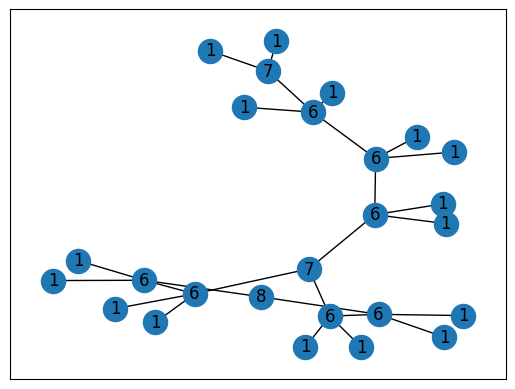

In [24]:
import numpy as np

adj_matrix=nx.to_numpy_array(G)
print(adj_matrix)

elements = nx.get_node_attributes(G, name = "atomic_num")

elems_array = [elements[key] for key in sorted(elements.keys())]
print(elems_array)
print(elements)

n=len(elems_array)
cols=116 # The number of atoms on the periodic table

# Initialize a matrix of zeros with n rows and 116 columns
element_matrix=np.zeros((n,cols),dtype=int)

# Set the corresponding column value in the matrix to 1 for each row based on the array values
for i, val in enumerate(elems_array):
    if 0 <= val < cols: #ensure the value is within the valid range of column indices
        element_matrix[i][val] = 1

display(element_matrix[:,1])
display(element_matrix[:,6])
print(adj_matrix.shape)
print(element_matrix.shape)

merged_matrix=np.concatenate((adj_matrix, element_matrix), axis=1)
print(merged_matrix.shape)

recover_adj_matrix=merged_matrix[:,0:merged_matrix.shape[0]]
print(recover_adj_matrix.shape)
recover_elem_matrix=merged_matrix[:,merged_matrix.shape[0]:merged_matrix.shape[1]]
print(recover_elem_matrix.shape)

nx.draw_networkx(G, with_labels=True, labels = elements, pos=nx.spring_layout(G))

Graph with 33 nodes and 36 edges
[HH]~C1~C(~[HH])~C(~[HH])~C2~C(~C~1~[HH])~C(~[HH])~C(~[HH])~C1~C~2~C(~[HH])~C(~C(~[HH])(~[HH])~[HH])~C2~C(~[HH])~C(~[HH])~C(~[HH])~C(~[HH])~C~1~2


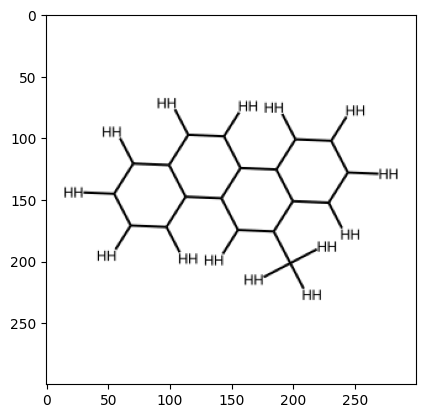

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

(26, 26)
(26, 116)
(80, 160)
(33, 33)
(33, 20)


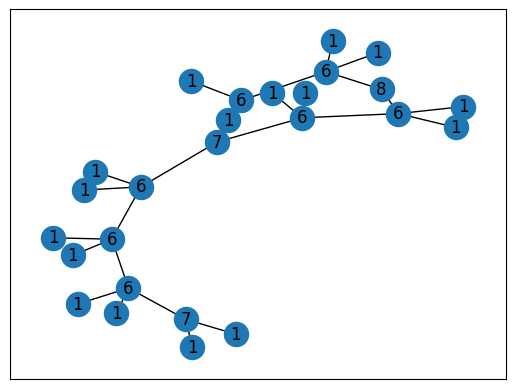

In [25]:
import numpy as np
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

def concat_with_zeros(array,n_max):
    array_with_zeros = np.pad(array, ((0,n_max-array.shape[0]),(0,n_max-array.shape[1])), mode='constant')
    return array_with_zeros

def remove_concat_zeros(array_with_zeros):
    mask = array_with_zeros == 0
    rows = np.flatnonzero((~mask).sum(axis=1))
    cols = np.flatnonzero((~mask).sum(axis=0))

    crop = array_with_zeros[rows.min():rows.max()+1, cols.min():cols.max()+1]
    return crop

def create_element_matrix_from_atomic_number_array(elems_array, n_max):
    n=len(elems_array)
    assert n <= n_max
    
    #cols=116 # The number of atoms on the periodic table
    cols=20 # The number of atoms on the periodic table


    # Initialize a matrix of zeros with n rows and 116 columns
    element_matrix=np.zeros((n,cols),dtype=int)

    # Set the corresponding column value in the matrix to 1 for each row based on the array values
    for i, val in enumerate(elems_array):
        if 0 <= val < cols: #ensure the value is within the valid range of column indices
            element_matrix[i][val] = 1
    element_matrix = concat_with_zeros(element_matrix,n_max)
    return element_matrix

def create_merged_adjacency_elements_matrix(adj_matrix, element_matrix):
    assert adj_matrix.shape[0] == element_matrix.shape[0]
    merged_matrix=np.concatenate((adj_matrix, element_matrix), axis=1)
    return merged_matrix

def recover_adjacency_and_elements_arrays(merged_matrix):
    adj_matrix=merged_matrix[:,0:merged_matrix.shape[0]]
    elem_matrix=merged_matrix[:,merged_matrix.shape[0]:merged_matrix.shape[1]]
    #import pdb; pdb.set_trace()
    adj_matrix=remove_concat_zeros(adj_matrix)
    elem_matrix=elem_matrix[:adj_matrix.shape[0], :20]
    return adj_matrix, elem_matrix

def convert_smiles_to_merged_adjacency_matrix(smiles, n_max):
    G=do_all(smiles)
    adj_matrix=nx.to_numpy_array(G)
    assert adj_matrix.shape[0] <= n_max
    adj_matrix = concat_with_zeros(adj_matrix,n_max)
    
    elements = nx.get_node_attributes(G, name = "atomic_num")
    elems_array = [elements[key] for key in sorted(elements.keys())]
    element_matrix=create_element_matrix_from_atomic_number_array(elems_array, n_max)
    merged_matrix=create_merged_adjacency_elements_matrix(adj_matrix, element_matrix)
    return merged_matrix

def recover_atomic_number_array_from_element_matrix(element_matrix):    
    # Recover the original array from the matrix
    recovered_array = [np.argmax(row) for row in element_matrix]
    return recovered_array

def recover_dict_from_atomic_number_array(array):
    recovered_dict = {}
    for i, row in enumerate(array):
        recovered_dict[i] = row.tolist()  # Convert numpy array row to list
    return recovered_dict

def convert_merged_adjacency_matrix_to_mol(merged_matrix):
    adj_matrix, elem_matrix=recover_adjacency_and_elements_arrays(merged_matrix)
    atom_number_array=recover_atomic_number_array_from_element_matrix(elem_matrix)
    element_dict=recover_dict_from_atomic_number_array(atom_number_array)
    G=nx.from_numpy_array(adj_matrix)
    print(G)
    nx.set_node_attributes(G,element_dict,'atomic_num')
    mol=nx_to_mol(G)
    return mol
    
#n_max=200
#n_elements_periodic_table=116

n_max=80
n_elements_periodic_table=20


#adj_matrix=nx.to_numpy_array(G)
#print(adj_matrix)

#elements = nx.get_node_attributes(G, name = "atomic_num")
#elems_array = [elements[key] for key in sorted(elements.keys())]
#print(elems_array)
#print(elements)

#element_matrix=create_element_matrix_from_atomic_number_array(elems_array,n_max)
#merged_matrix=create_merged_adjacency_elements_matrix(adj_matrix, element_matrix)

smiles='CC1=CC2=C(C=CC3=CC=CC=C32)C4=CC=CC=C14'

merged_matrix=convert_smiles_to_merged_adjacency_matrix(smiles, n_max)
recover_adj_matrix,recover_elem_matrix= recover_adjacency_and_elements_arrays(merged_matrix)
mol=convert_merged_adjacency_matrix_to_mol(merged_matrix)
smi = Chem.MolToSmiles(mol)
print(smi)

#mol = Chem.AddHs(mol,explicitOnly=True)
img = Draw.MolToImage(mol)
imgplot = plt.imshow(img)
plt.show()

display(element_matrix[:,1])
display(element_matrix[:,6])
print(adj_matrix.shape)
print(element_matrix.shape)
print(merged_matrix.shape)
print(recover_adj_matrix.shape)
print(recover_elem_matrix.shape)


nx.draw_networkx(G, with_labels=True, labels = elements, pos=nx.spring_layout(G))

In [26]:
#https://github.com/rdkit/rdkit/tree/master/Docs/Notebooks

# Generate molecular fingerprints
adjmatrices = []

for smiles in df['smiles']:
    adjmat = convert_smiles_to_merged_adjacency_matrix(smiles, n_max)
    adjmatrices.append(adjmat)

In [27]:
df['Merged Adjacency Matrix'] = adjmatrices

(80, 160)


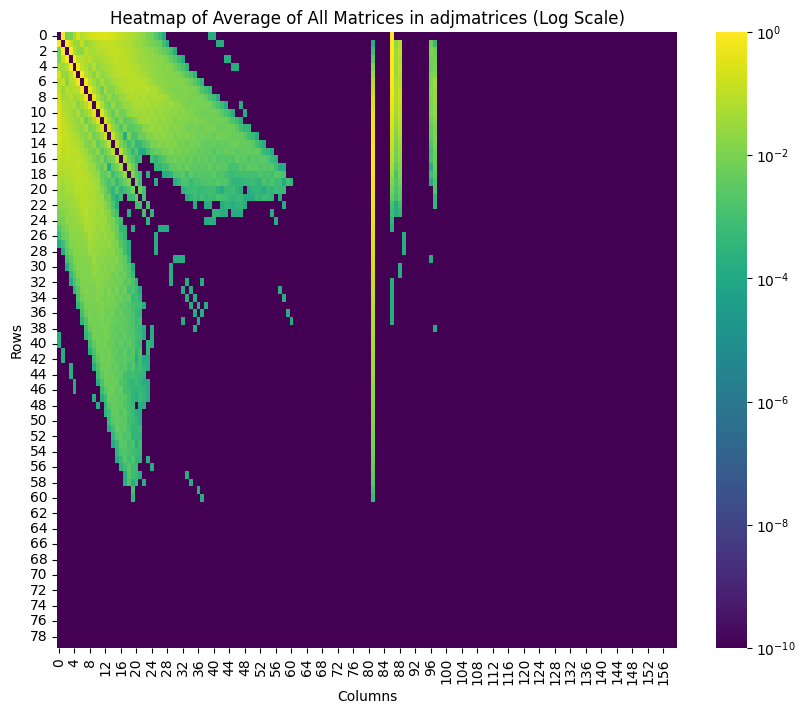

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Calculate the average matrix
average_matrix = np.mean(adjmatrices, axis=0)
print(average_matrix.shape)

# Ensure all values are positive for the log scale
average_matrix = np.clip(average_matrix, a_min=1e-10, a_max=None)

# Plot the heatmap with a logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(
    average_matrix, 
    cmap='viridis', 
    norm=LogNorm(),  # Apply logarithmic normalization
    cbar=True
)

plt.title('Heatmap of Average of All Matrices in adjmatrices (Log Scale)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [31]:
import numpy as np
import pandas as pd

# df['Merged Adjacency Matrix'] contains 2D numpy array that cannot be saved to a parquet file

# Step 1: Store original matrix shapes
df['Matrix_Shape'] = df['Merged Adjacency Matrix'].apply(lambda x: np.array(x).shape)

# Step 2: Flatten each matrix to 1D
df['Merged Adjacency Matrix'] = df['Merged Adjacency Matrix'].apply(lambda x: np.array(x).flatten())


In [32]:
#Dump dataframe to pickle. -> 250 MB file
import pickle 
import os.path

path = './'+'IR_v09_df_all_features.parquet'
df.to_parquet(path)

In [6]:
import pandas as pd
import numpy as np
# Load the Parquet file
df = pd.read_parquet("IR_v09_df_all_features.parquet")

# Reconstruct the original 2D matrices
df['Merged Adjacency Matrix'] = df.apply(
    lambda row: np.array(row['Merged Adjacency Matrix']).reshape(row['Matrix_Shape']),
    axis=1
)

In [ ]:
### GO TO END OF CODE AND TURN ON TENSORBOARD

In [ ]:
# Binary Multilable Classification: What happens if we use MSELoss?

**Types of Loss for Multi-label classification**
- **BCELoss**: Standard loss for multi-label classification; treats each label independently.
- **BCEWithLogitsLoss**: More stable version of BCELoss; combines sigmoid + binary cross-entropy.
- **Weighted BCE**: Adds class weights to handle label imbalance by emphasizing rare labels.
- **Focal Loss**: Focuses training on hard examples by down-weighting easy ones.


**Strategies for Thresholding**
- **Fixed Threshold**: Apply a constant value (e.g., 0.5) across all labels; simple but may miss rare classes.
- **Per-Label Thresholds**: Customize thresholds per class to better handle imbalanced labels and improve metrics.
- **Threshold Tuning**: Use validation data to optimize thresholds for F1, precision, or recall.


**Confusion Matrix:**
In multi-label classification, a confusion matrix is computed per label to evaluate true/false positives and negatives. It helps identify which classes are misclassified. Metrics like precision, recall, and F1 are derived from these matrices. Visualizing per-label confusion matrices reveals model strengths, weaknesses, and label-specific performance.

Epoch [100/5000], Loss: 685.9200, Val Loss: 685.6456, LR: 0.000050
Epoch [200/5000], Loss: 550.5255, Val Loss: 546.8026, LR: 0.000030
Epoch [300/5000], Loss: 436.0029, Val Loss: 433.3676, LR: 0.000050
Epoch [400/5000], Loss: 265.2693, Val Loss: 263.7130, LR: 0.000044
Epoch [500/5000], Loss: 229.0742, Val Loss: 228.2563, LR: 0.000030
Epoch [600/5000], Loss: 217.1708, Val Loss: 216.4254, LR: 0.000016
Epoch [700/5000], Loss: 212.1822, Val Loss: 211.4550, LR: 0.000050
Epoch [800/5000], Loss: 194.8433, Val Loss: 194.1288, LR: 0.000048
Epoch [900/5000], Loss: 179.4484, Val Loss: 179.1341, LR: 0.000044
Epoch [1000/5000], Loss: 166.1448, Val Loss: 166.4007, LR: 0.000038
Epoch [1100/5000], Loss: 155.6682, Val Loss: 156.4373, LR: 0.000030
Epoch [1200/5000], Loss: 148.0900, Val Loss: 149.2272, LR: 0.000022
Epoch [1300/5000], Loss: 142.9205, Val Loss: 144.4116, LR: 0.000016
Epoch [1400/5000], Loss: 139.3510, Val Loss: 141.1856, LR: 0.000012
Epoch [1500/5000], Loss: 136.6656, Val Loss: 138.7380, LR

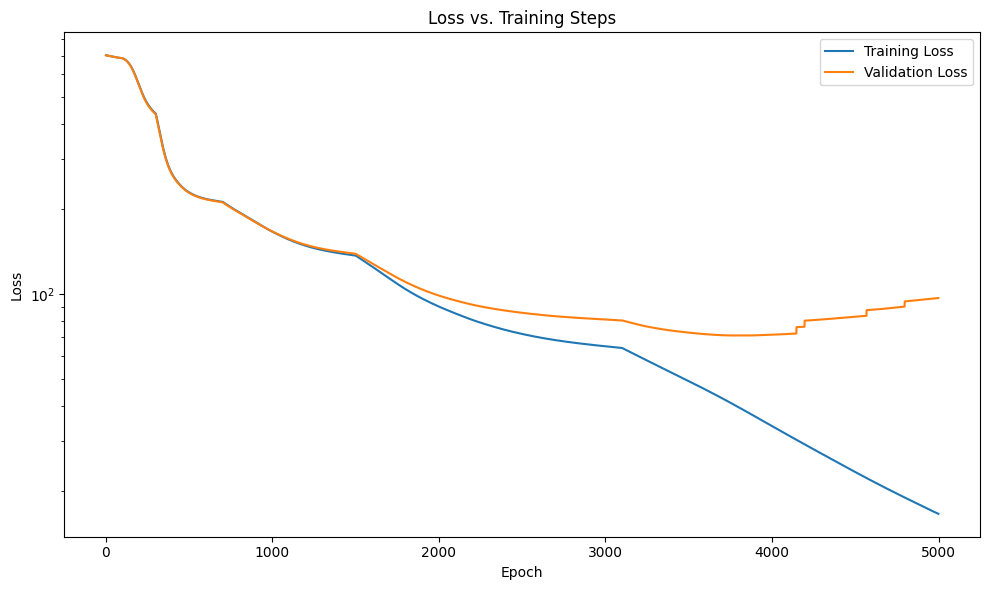


Metrics for Allenic:
  Accuracy:  0.9982
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

Metrics for Vinylic:
  Accuracy:  0.9171
  Precision: 0.7016
  Recall:    0.7836
  F1 Score:  0.7403

Metrics for Arene:
  Accuracy:  0.9515
  Precision: 0.9379
  Recall:    0.9736
  F1 Score:  0.9554

Metrics for Alcohol:
  Accuracy:  0.9656
  Precision: 0.9211
  Recall:    0.9542
  F1 Score:  0.9374

Metrics for Ether:
  Accuracy:  0.9559
  Precision: 0.8827
  Recall:    0.9597
  F1 Score:  0.9196

Metrics for Amine:
  Accuracy:  0.9700
  Precision: 0.8299
  Recall:    0.9313
  F1 Score:  0.8777

Metrics for Imine:
  Accuracy:  0.9965
  Precision: 1.0000
  Recall:    0.4286
  F1 Score:  0.6000

Metrics for Nitrile:
  Accuracy:  0.9480
  Precision: 0.4762
  Recall:    0.5357
  F1 Score:  0.5042

Metrics for Thiol:
  Accuracy:  0.9921
  Precision: 0.4444
  Recall:    0.5000
  F1 Score:  0.4706

Metrics for Sulfide:
  Accuracy:  1.0000
  Precision: 0.0000
  Recall:    0.0000
  F1 Score

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from io import BytesIO
from PIL import Image

##############################################
# Declare the neural network for multi-label classification
##############################################

class MultiLabelNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(MultiLabelNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.hidden4 = nn.Linear(H3, H4)
        self.output = nn.Linear(H4, D_out)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        return torch.sigmoid(self.output(x))  # Sigmoid for multi-label classification

##############################################
# Prepare data (assuming df is a preloaded DataFrame)
##############################################

# Extract the input data (1D arrays) from 'y' column with log transformation
X = np.log(np.vstack(df['y'].values) + 1)

# Extract multi-label targets based on functional groups
functional_groups = [
    'Allenic', 'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 
    'Imine', 'Nitrile', 'Thiol', 'Sulfide', 'Disulfide', 
    'Aldehyde', 'Ketone', 'CarboxylAcid', 'Ester',
    'Thioester', 'Amide', 'AcidChloride', 'Anhydride'
]
y = df[functional_groups].values  # Extract functional group labels

# Standardize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

##############################################
# Create the model and set up optimization
##############################################

D_in = X_train_tensor.shape[1]
H1, H2, H3, H4 = 128, 64, 32, 64
D_out = len(functional_groups)

net = MultiLabelNN(D_in, H1, H2, H3, H4, D_out)

# Use Adam optimizer with a learning rate scheduler
learning_rate = 0.00005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.BCELoss()

# Initialize TensorBoard writer
writer = SummaryWriter()
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop
##############################################

num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = net(X_train_tensor)
    loss = 1000 * criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    # Validation loss
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_loss = 1000 * criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Log losses and learning rate to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)
    writer.add_scalar('Loss/validation', val_loss.item(), epoch)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, LR: {current_lr:.6f}')

##############################################
# Plot Loss Curves
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Training Steps')
plt.legend()
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image = Image.open(buf)
writer.add_image('Loss Curve', np.array(image), dataformats='HWC')
buf.close()
plt.show()

##############################################
# Evaluate the Model
##############################################

net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)

y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()
y_pred_binary = (y_pred >= 0.2).astype(int)

##############################################
# Calculate Per-Label Metrics
##############################################

for i, group in enumerate(functional_groups):
    acc = accuracy_score(y_test[:, i], y_pred_binary[:, i])
    prec = precision_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    rec = recall_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)

    print(f"\nMetrics for {group}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    writer.add_scalar(f'Metrics/{group}_Accuracy', acc)
    writer.add_scalar(f'Metrics/{group}_Precision', prec)
    writer.add_scalar(f'Metrics/{group}_Recall', rec)
    writer.add_scalar(f'Metrics/{group}_F1_Score', f1)

# Close the TensorBoard writer
writer.close()


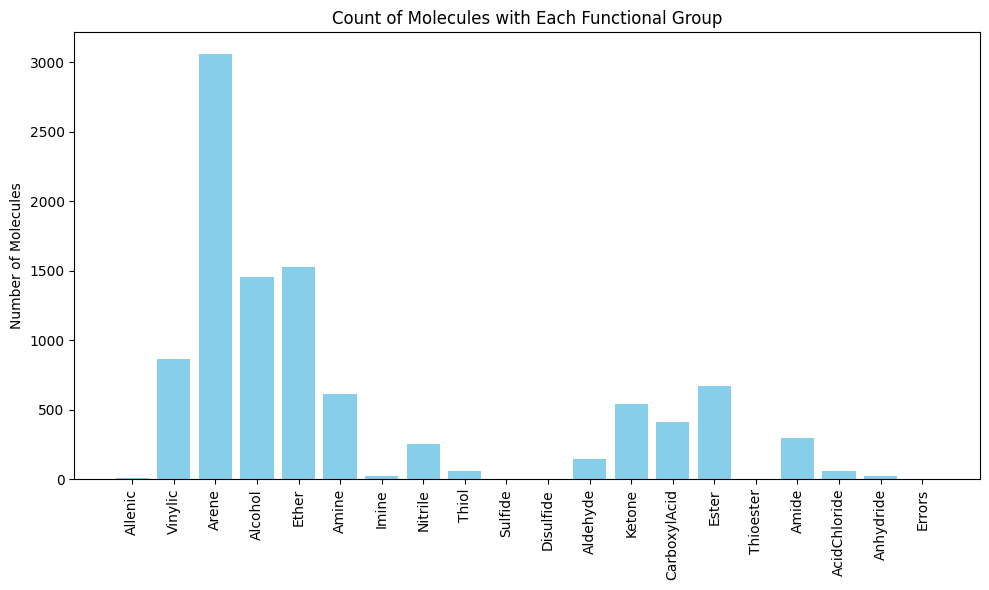

In [40]:
import matplotlib.pyplot as plt

# List of functional groups
functional_groups = ['Allenic', 'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 'Imine', 
                     'Nitrile', 'Thiol', 'Sulfide', 'Disulfide', 'Aldehyde', 'Ketone', 
                     'CarboxylAcid', 'Ester', 'Thioester', 'Amide', 'AcidChloride', 'Anhydride','Errors']

# Calculate the sum of each functional group column
group_counts = df[functional_groups].sum()

# Create a bar plot
plt.figure(figsize=(10,6))
plt.bar(group_counts.index, group_counts.values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.ylabel('Number of Molecules')
plt.title('Count of Molecules with Each Functional Group')
plt.tight_layout()

# Show the plot
plt.show()


 **Top 3 Class Balancing Strategies (Multi-Label)**

 1. **Multilabel Stratified Splitting** – Use `MultilabelStratifiedShuffleSplit` to preserve label proportions across train/test splits.
 2. **Class Weighting in Loss Function** – Apply inverse frequency weights in `BCELoss` to emphasize rare labels during training.
 3. **Oversampling Rare Labels** – Duplicate or synthesize examples with rare labels to boost their representation in the training set.


In [4]:
#%pip install iterative-stratification

Epoch [100/5000], Loss: 669.0858, Val Loss: 669.3001, LR: 0.000050
Epoch [200/5000], Loss: 597.1957, Val Loss: 596.6018, LR: 0.000030
Epoch [300/5000], Loss: 523.4028, Val Loss: 523.2303, LR: 0.000050
Epoch [400/5000], Loss: 351.6732, Val Loss: 352.7872, LR: 0.000044
Epoch [500/5000], Loss: 303.5861, Val Loss: 306.2160, LR: 0.000030
Epoch [600/5000], Loss: 284.4886, Val Loss: 287.1867, LR: 0.000016
Epoch [700/5000], Loss: 276.1596, Val Loss: 278.7866, LR: 0.000050
Epoch [800/5000], Loss: 250.2337, Val Loss: 252.1067, LR: 0.000048
Epoch [900/5000], Loss: 228.1255, Val Loss: 229.9593, LR: 0.000044
Epoch [1000/5000], Loss: 206.7760, Val Loss: 209.2751, LR: 0.000038
Epoch [1100/5000], Loss: 189.6010, Val Loss: 193.2100, LR: 0.000030
Epoch [1200/5000], Loss: 178.3043, Val Loss: 182.8986, LR: 0.000022
Epoch [1300/5000], Loss: 171.2147, Val Loss: 176.4792, LR: 0.000016
Epoch [1400/5000], Loss: 166.6536, Val Loss: 172.3249, LR: 0.000012
Epoch [1500/5000], Loss: 163.3125, Val Loss: 169.2809, LR

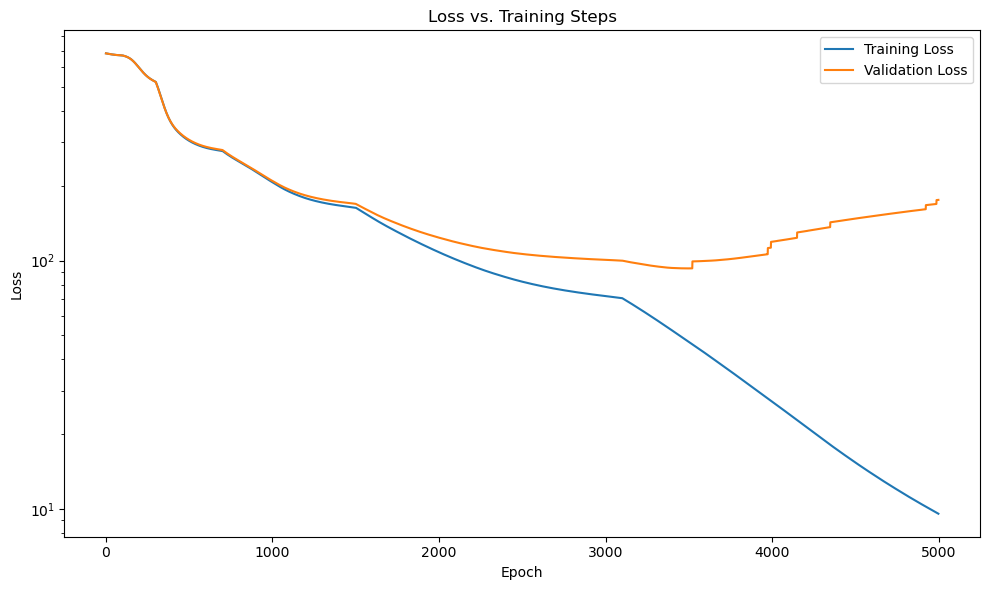


Metrics for Vinylic:
  Accuracy:  0.9268
  Precision: 0.7394
  Recall:    0.8035
  F1 Score:  0.7701

Metrics for Arene:
  Accuracy:  0.9621
  Precision: 0.9538
  Recall:    0.9772
  F1 Score:  0.9654

Metrics for Alcohol:
  Accuracy:  0.9718
  Precision: 0.9358
  Recall:    0.9552
  F1 Score:  0.9454

Metrics for Ether:
  Accuracy:  0.9471
  Precision: 0.8773
  Recall:    0.9346
  F1 Score:  0.9051

Metrics for Amine:
  Accuracy:  0.9727
  Precision: 0.8421
  Recall:    0.9180
  F1 Score:  0.8784

Metrics for Nitrile:
  Accuracy:  0.9559
  Precision: 0.5079
  Recall:    0.6275
  F1 Score:  0.5614

Metrics for Aldehyde:
  Accuracy:  0.9974
  Precision: 0.9643
  Recall:    0.9310
  F1 Score:  0.9474

Metrics for Ketone:
  Accuracy:  0.9550
  Precision: 0.7317
  Recall:    0.8333
  F1 Score:  0.7792

Metrics for CarboxylAcid:
  Accuracy:  0.9868
  Precision: 0.9136
  Recall:    0.9024
  F1 Score:  0.9080

Metrics for Ester:
  Accuracy:  0.9762
  Precision: 0.8690
  Recall:    0.9403
  F

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from io import BytesIO
from PIL import Image

# Add this import for class-balanced splitting
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

##############################################
# Declare the neural network for multi-label classification
##############################################

class MultiLabelNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(MultiLabelNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.hidden4 = nn.Linear(H3, H4)
        self.output = nn.Linear(H4, D_out)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        return torch.sigmoid(self.output(x))  # Sigmoid for multi-label classification

##############################################
# Prepare data (assuming df is a preloaded DataFrame)
##############################################

# Extract the input data (1D arrays) from 'y' column with log transformation
X = np.log(np.vstack(df['y'].values) + 1)

# Extract multi-label targets based on functional groups
functional_groups = [
    'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 
    'Nitrile', 'Aldehyde', 'Ketone', 'CarboxylAcid', 'Ester',
    'Amide', 'AcidChloride'
]
y = df[functional_groups].values  # Extract functional group labels

# Standardize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use multilabel stratified shuffle split for class balancing
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(msss.split(X, y))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

##############################################
# Create the model and set up optimization
##############################################

D_in = X_train_tensor.shape[1]
H1, H2, H3, H4 = 128, 64, 32, 64
D_out = len(functional_groups)

net = MultiLabelNN(D_in, H1, H2, H3, H4, D_out)

# Use Adam optimizer with a learning rate scheduler
learning_rate = 0.00005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.BCELoss()

# Initialize TensorBoard writer
writer = SummaryWriter()
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop
##############################################

num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    outputs = net(X_train_tensor)
    loss = 1000 * criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    # Validation
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_loss = 1000 * criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Log to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)
    writer.add_scalar('Loss/validation', val_loss.item(), epoch)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, LR: {current_lr:.6f}')

##############################################
# Plot Loss Curves
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Training Steps')
plt.legend()
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image = Image.open(buf)
writer.add_image('Loss Curve', np.array(image), dataformats='HWC')
buf.close()
plt.show()

##############################################
# Evaluate the Model
##############################################

net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)

y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()
y_pred_binary = (y_pred >= 0.2).astype(int)

##############################################
# Calculate Per-Label Metrics
##############################################

for i, group in enumerate(functional_groups):
    acc = accuracy_score(y_test[:, i], y_pred_binary[:, i])
    prec = precision_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    rec = recall_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)

    print(f"\nMetrics for {group}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    writer.add_scalar(f'Metrics/{group}_Accuracy', acc)
    writer.add_scalar(f'Metrics/{group}_Precision', prec)
    writer.add_scalar(f'Metrics/{group}_Recall', rec)
    writer.add_scalar(f'Metrics/{group}_F1_Score', f1)

writer.close()


**Average Metric Changes With Class Balancing**

| Metric     | Average Change |
|------------|----------------|
| Accuracy   | +0.0025        |
| Precision  | +0.0314        |
| Recall     | –0.0040        |
| F1 Score   | +0.0171        |


In [10]:
df.keys()

Index(['NIST_molecule', 'CAS_NO', 'Name', 'molform', 'x', 'y', 'smiles',
       'Allenic', 'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 'Imine',
       'Nitrile', 'Thiol', 'Sulfide', 'Disulfide', 'Aldehyde', 'Ketone',
       'CarboxylAcid', 'Ester', 'Thioester', 'Amide', 'AcidChloride',
       'Anhydride', 'Errors', 'Merged Adjacency Matrix', 'Matrix_Shape'],
      dtype='object')

In [11]:
df.keys()

Index(['NIST_molecule', 'CAS_NO', 'Name', 'molform', 'x', 'y', 'smiles',
       'Allenic', 'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 'Imine',
       'Nitrile', 'Thiol', 'Sulfide', 'Disulfide', 'Aldehyde', 'Ketone',
       'CarboxylAcid', 'Ester', 'Thioester', 'Amide', 'AcidChloride',
       'Anhydride', 'Errors', 'Merged Adjacency Matrix', 'Matrix_Shape'],
      dtype='object')

Evaluating thresholds: 100%|███████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


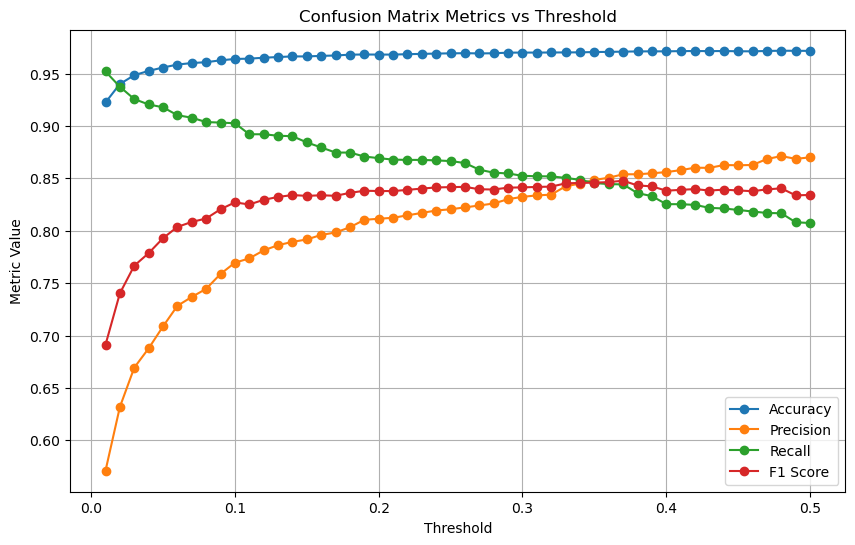

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define a range of thresholds to explore (e.g., from 0.01 to 0.5)
thresholds = np.linspace(0.01, 0.5, 50)

# Initialize dictionaries to store metrics for each threshold
confusion_matrix_metrics = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

##############################################
# Evaluate the Model with Different Thresholds
##############################################

for threshold in tqdm(thresholds, desc="Evaluating thresholds"):
    # Apply the threshold to convert probabilities to binary predictions
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Initialize cumulative metrics for all labels (to average later)
    total_acc, total_prec, total_rec, total_f1 = 0, 0, 0, 0

    # Calculate metrics per functional group
    for i, group in enumerate(functional_groups):
        # Calculate confusion matrix and per-label metrics
        tn, fp, fn, tp = confusion_matrix(y_test[:, i], y_pred_binary[:, i]).ravel()

        acc = accuracy_score(y_test[:, i], y_pred_binary[:, i])
        prec = precision_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
        rec = recall_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
        f1 = f1_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)

        # Accumulate metrics for averaging across all labels
        total_acc += acc
        total_prec += prec
        total_rec += rec
        total_f1 += f1

    # Average metrics across all functional groups
    avg_acc = total_acc / len(functional_groups)
    avg_prec = total_prec / len(functional_groups)
    avg_rec = total_rec / len(functional_groups)
    avg_f1 = total_f1 / len(functional_groups)

    # Store metrics for this threshold
    confusion_matrix_metrics['threshold'].append(threshold)
    confusion_matrix_metrics['accuracy'].append(avg_acc)
    confusion_matrix_metrics['precision'].append(avg_prec)
    confusion_matrix_metrics['recall'].append(avg_rec)
    confusion_matrix_metrics['f1_score'].append(avg_f1)

##############################################
# Plot Metrics vs Threshold
##############################################

plt.figure(figsize=(10, 6))

# Plot each metric against the threshold
plt.plot(confusion_matrix_metrics['threshold'], confusion_matrix_metrics['accuracy'], label='Accuracy', marker='o')
plt.plot(confusion_matrix_metrics['threshold'], confusion_matrix_metrics['precision'], label='Precision', marker='o')
plt.plot(confusion_matrix_metrics['threshold'], confusion_matrix_metrics['recall'], label='Recall', marker='o')
plt.plot(confusion_matrix_metrics['threshold'], confusion_matrix_metrics['f1_score'], label='F1 Score', marker='o')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Confusion Matrix Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


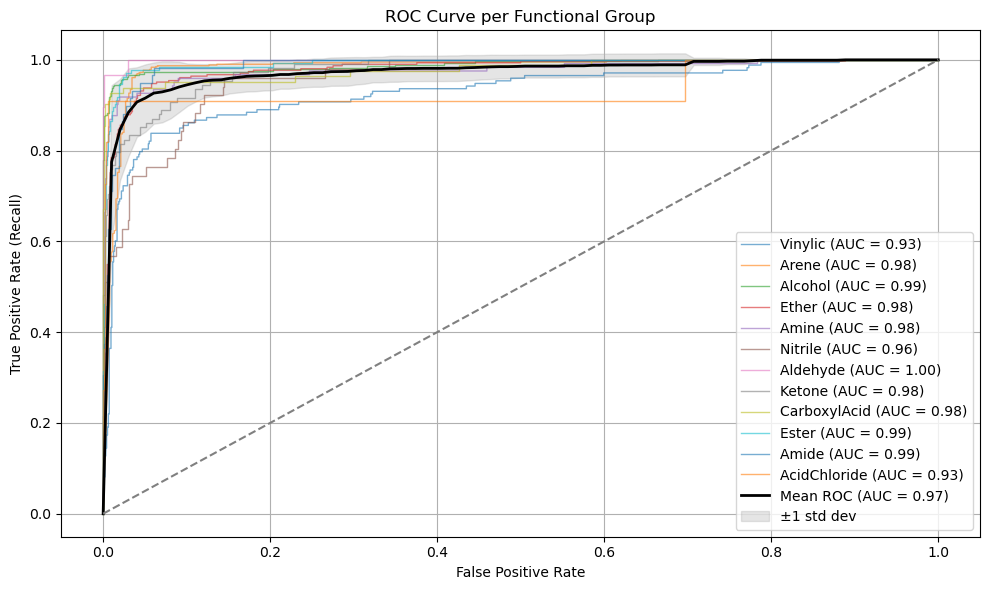

In [14]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Initialize TPR and FPR lists for ROC
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

plt.figure(figsize=(10, 6))

# Plot ROC curve per label and compute AUC
for i, group in enumerate(functional_groups):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)  # interpolate to common FPR axis
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f'{group} (AUC = {roc_auc:.2f})')

# Compute mean TPR and std deviation across all groups
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='±1 std dev')

# Plot diagonal reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve per Functional Group")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


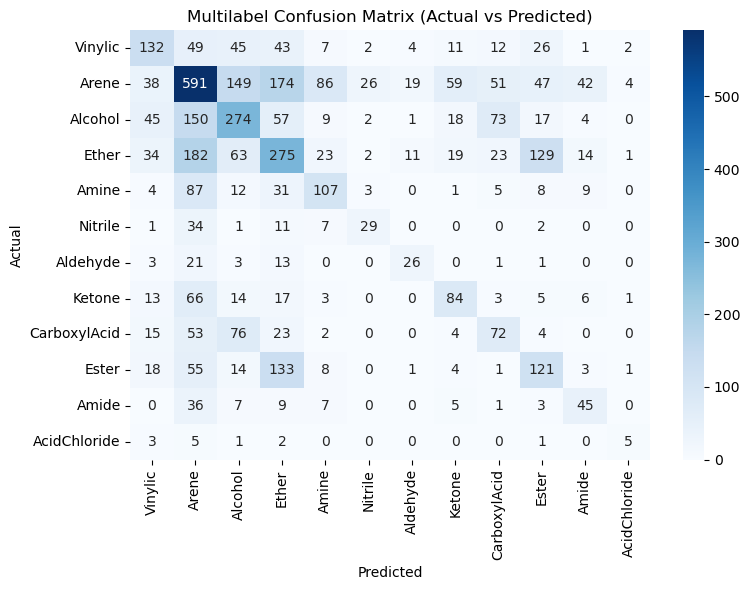

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import multilabel_confusion_matrix

# Threshold to binarize predictions
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Number of classes
n_classes = y_test.shape[1]
labels = functional_groups  # list of class names, length = n_classes

# Create the confusion matrix array for each class: shape (n_classes, 2, 2)
ml_conf_matrices = multilabel_confusion_matrix(y_test, y_pred_binary)

# Now build a label x label confusion table
conf_table = np.zeros((n_classes, n_classes), dtype=int)

# Go through each sample and tally actual→predicted combinations
for yt, yp in zip(y_test, y_pred_binary):
    actual_idx = np.where(yt == 1)[0]
    pred_idx = np.where(yp == 1)[0]
    for a in actual_idx:
        for p in pred_idx:
            conf_table[a, p] += 1

# Convert to DataFrame for labeling
conf_df = pd.DataFrame(conf_table,
                       index=pd.Index(labels, name="Actual"),
                       columns=pd.Index(labels, name="Predicted"))

# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap="Blues")
plt.title("Multilabel Confusion Matrix (Actual vs Predicted)")
plt.tight_layout()
plt.show()


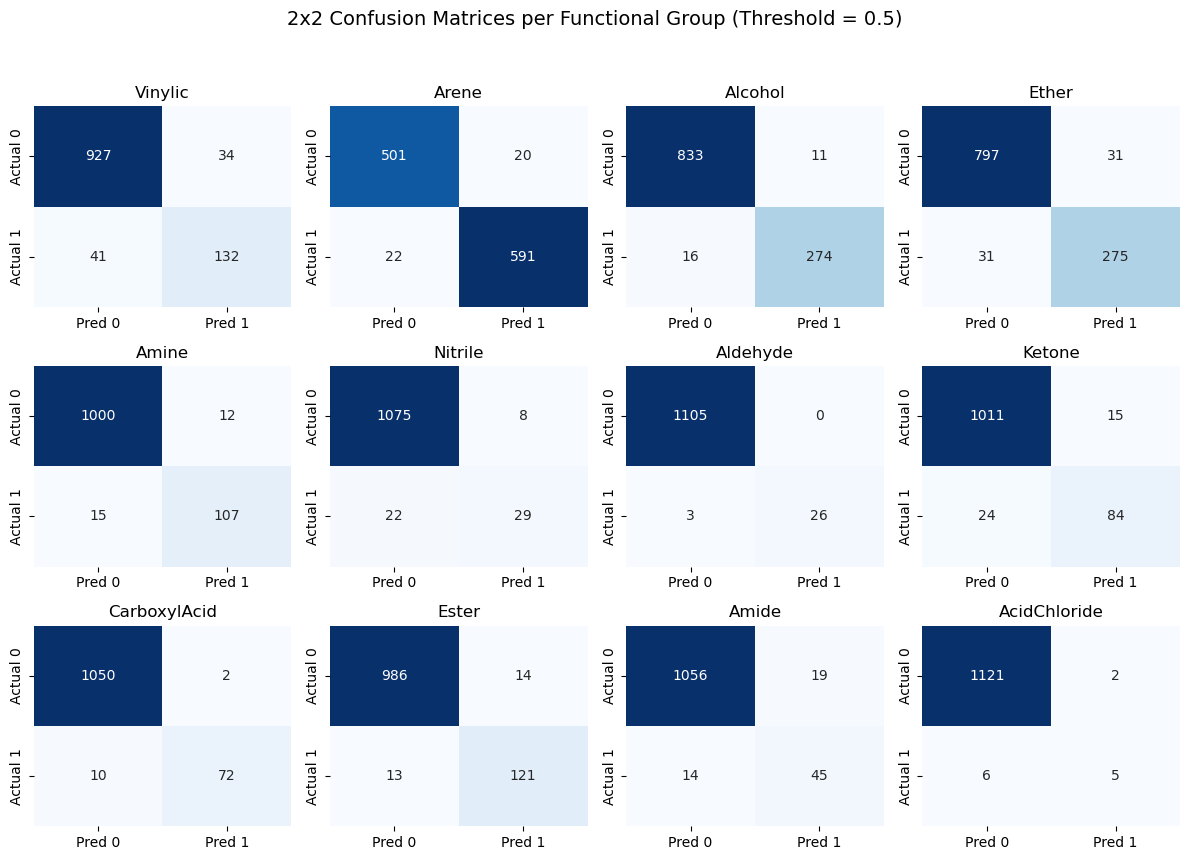

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# Apply a fixed threshold to get binary predictions
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Grid size (auto-detect best square layout)
n_groups = len(functional_groups)
cols = 4  # You can customize this
rows = math.ceil(n_groups / cols)

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Flatten axes for easier indexing
axes = axes.flatten()

for i, group in enumerate(functional_groups):
    # Compute 2x2 confusion matrix for each class
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    
    # Plot on corresponding subplot
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"], ax=ax)
    ax.set_title(f"{group}")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"2x2 Confusion Matrices per Functional Group (Threshold = {threshold})", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Epoch [100/5000], Train Loss: 3.1450, Val Loss: 3.5213, LR: 0.000050
Epoch [200/5000], Train Loss: 3.0268, Val Loss: 3.4007, LR: 0.000030
Epoch [300/5000], Train Loss: 2.9026, Val Loss: 3.4061, LR: 0.000050
Epoch [400/5000], Train Loss: 2.7161, Val Loss: 3.2423, LR: 0.000044
Epoch [500/5000], Train Loss: 2.6550, Val Loss: 3.2164, LR: 0.000030
Epoch [600/5000], Train Loss: 2.6020, Val Loss: 3.1118, LR: 0.000016
Epoch [700/5000], Train Loss: 2.5604, Val Loss: 3.0996, LR: 0.000050
Epoch [800/5000], Train Loss: 2.3745, Val Loss: 3.0333, LR: 0.000048
Epoch [900/5000], Train Loss: 2.1565, Val Loss: 2.6936, LR: 0.000044
Epoch [1000/5000], Train Loss: 2.0180, Val Loss: 2.3092, LR: 0.000038
Epoch [1100/5000], Train Loss: 1.8881, Val Loss: 2.0613, LR: 0.000030
Epoch [1200/5000], Train Loss: 1.7911, Val Loss: 1.9845, LR: 0.000022
Epoch [1300/5000], Train Loss: 1.7215, Val Loss: 1.9342, LR: 0.000016
Epoch [1400/5000], Train Loss: 1.6681, Val Loss: 1.9186, LR: 0.000012
Epoch [1500/5000], Train Loss

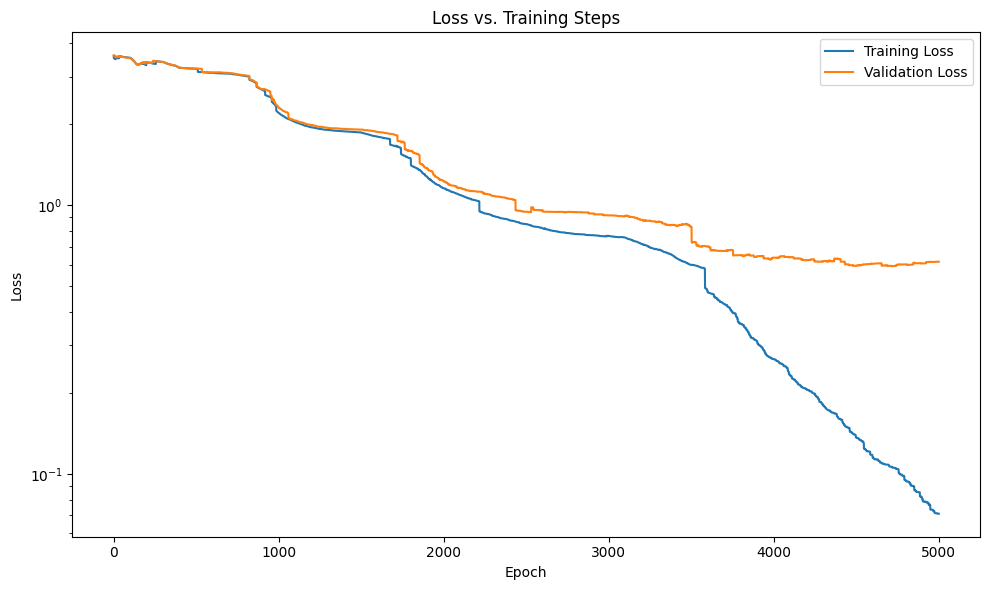


Metrics for Vinylic:
  Accuracy:  0.9392
  Precision: 0.8148
  Recall:    0.7719
  F1 Score:  0.7928

Metrics for Arene:
  Accuracy:  0.9533
  Precision: 0.9539
  Recall:    0.9587
  F1 Score:  0.9563

Metrics for Alcohol:
  Accuracy:  0.9700
  Precision: 0.9658
  Recall:    0.9216
  F1 Score:  0.9431

Metrics for Ether:
  Accuracy:  0.9630
  Precision: 0.9211
  Recall:    0.9396
  F1 Score:  0.9302

Metrics for Amine:
  Accuracy:  0.9744
  Precision: 0.9113
  Recall:    0.8626
  F1 Score:  0.8863

Metrics for Nitrile:
  Accuracy:  0.9674
  Precision: 0.7436
  Recall:    0.5179
  F1 Score:  0.6105

Metrics for Aldehyde:
  Accuracy:  0.9938
  Precision: 0.9167
  Recall:    0.8148
  F1 Score:  0.8627

Metrics for Ketone:
  Accuracy:  0.9762
  Precision: 0.9250
  Recall:    0.7789
  F1 Score:  0.8457

Metrics for CarboxylAcid:
  Accuracy:  0.9841
  Precision: 0.9324
  Recall:    0.8415
  F1 Score:  0.8846

Metrics for Ester:
  Accuracy:  0.9824
  Precision: 0.9343
  Recall:    0.9209
  F

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

##############################################
# Prepare Data with the Top 1000 Features by Correlation
##############################################

# Use the top 1000 feature names identified earlier
X_top_1000_correlation = X_df[top_feature_variance_names].values  # Extract top 1000 features
X = np.log(np.vstack(df['y'].values) + 1)
# Extract multi-label targets based on functional groups
functional_groups = [
    'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 
    'Nitrile', 'Aldehyde', 'Ketone', 'CarboxylAcid', 'Ester',
    'Amide', 'AcidChloride'
]
y = df[functional_groups].values  # Extract functional group labels

# Standardize the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top_1000_correlation)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

##############################################
# Declare the Neural Network for Multi-Label Classification
##############################################

class MultiLabelNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(MultiLabelNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.hidden4 = nn.Linear(H3, H4)
        self.output = nn.Linear(H4, D_out)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        return torch.sigmoid(self.output(x))  # Sigmoid for multi-label classification
# Initialize the network with the input size matching the top 1000 features
D_in = X_train_tensor.shape[1]
H1, H2, H3, H4 = 128, 64, 32, 64
D_out = len(functional_groups)

net = MultiLabelNN(D_in, H1, H2, H3, H4, D_out)

##############################################
# Set Up Optimization and Custom Loss Function
##############################################

learning_rate = 0.00005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)

# Initialize TensorBoard writer
writer = SummaryWriter()
writer.add_text('Hyperparameters', f'Initial Learning Rate: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop with Custom Combined Loss
##############################################

num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = net(X_train_tensor)
    bce_loss = nn.BCELoss()(outputs, y_train_tensor)  # Base BCE loss

    # Convert predictions to binary using a threshold for metric calculation
    y_pred_binary = (outputs.detach().numpy() >= 0.2).astype(int)
    y_train_np = y_train_tensor.numpy()

    # Calculate metrics
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    for i in range(D_out):
        acc = accuracy_score(y_train_np[:, i], y_pred_binary[:, i])
        prec = precision_score(y_train_np[:, i], y_pred_binary[:, i], zero_division=0)
        rec = recall_score(y_train_np[:, i], y_pred_binary[:, i], zero_division=0)
        f1 = f1_score(y_train_np[:, i], y_pred_binary[:, i], zero_division=0)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

    # Calculate custom combined loss (lower is better as metrics approach 1)
    acc_loss = 1 - np.mean(acc_list)
    prec_loss = 1 - np.mean(prec_list)
    rec_loss = 1 - np.mean(rec_list)
    f1_loss = 1 - np.mean(f1_list)
    combined_loss = bce_loss + acc_loss + prec_loss + rec_loss + f1_loss

    # Backpropagation and optimization
    combined_loss.backward()
    optimizer.step()
    scheduler.step()
    
    with torch.no_grad():
        trn_outputs = net(X_train_tensor)
        trn_bce_loss = nn.BCELoss()(trn_outputs, y_train_tensor)

        # Convert predictions to binary for validation metrics
        trn_y_pred_binary = (trn_outputs.numpy() >= 0.5).astype(int)
        trn_acc_list, trn_prec_list, trn_rec_list, trn_f1_list = [], [], [], []
        for i in range(D_out):
            trn_acc = accuracy_score(y_train[:, i], trn_y_pred_binary[:, i])
            trn_prec = precision_score(y_train[:, i], trn_y_pred_binary[:, i], zero_division=0)
            trn_rec = recall_score(y_train[:, i], trn_y_pred_binary[:, i], zero_division=0)
            trn_f1 = f1_score(y_train[:, i], trn_y_pred_binary[:, i], zero_division=0)
            trn_acc_list.append(trn_acc)
            trn_prec_list.append(trn_prec)
            trn_rec_list.append(trn_rec)
            trn_f1_list.append(trn_f1)

        trn_acc_loss = 1 - np.mean(trn_acc_list)
        trn_prec_loss = 1 - np.mean(trn_prec_list)
        trn_rec_loss = 1 - np.mean(trn_rec_list)
        trn_f1_loss = 1 - np.mean(trn_f1_list)
        trn_combined_loss = trn_bce_loss + trn_acc_loss + trn_prec_loss + trn_rec_loss + trn_f1_loss

        train_losses.append(trn_combined_loss.item())

    # Validation loss
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_bce_loss = nn.BCELoss()(val_outputs, y_test_tensor)

        # Convert predictions to binary for validation metrics
        val_y_pred_binary = (val_outputs.numpy() >= 0.5).astype(int)
        val_acc_list, val_prec_list, val_rec_list, val_f1_list = [], [], [], []
        for i in range(D_out):
            val_acc = accuracy_score(y_test[:, i], val_y_pred_binary[:, i])
            val_prec = precision_score(y_test[:, i], val_y_pred_binary[:, i], zero_division=0)
            val_rec = recall_score(y_test[:, i], val_y_pred_binary[:, i], zero_division=0)
            val_f1 = f1_score(y_test[:, i], val_y_pred_binary[:, i], zero_division=0)
            val_acc_list.append(val_acc)
            val_prec_list.append(val_prec)
            val_rec_list.append(val_rec)
            val_f1_list.append(val_f1)

        val_acc_loss = 1 - np.mean(val_acc_list)
        val_prec_loss = 1 - np.mean(val_prec_list)
        val_rec_loss = 1 - np.mean(val_rec_list)
        val_f1_loss = 1 - np.mean(val_f1_list)
        val_combined_loss = val_bce_loss + val_acc_loss + val_prec_loss + val_rec_loss + val_f1_loss

        val_losses.append(val_combined_loss.item())

    # Log losses and learning rate to TensorBoard
    writer.add_scalar('Loss/train', combined_loss.item(), epoch)
    writer.add_scalar('Loss/validation', val_combined_loss.item(), epoch)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {combined_loss:.4f}, Val Loss: {val_combined_loss:.4f}, LR: {current_lr:.6f}')

##############################################
# Plot Loss Curves
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Training Steps')
plt.legend()
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image = Image.open(buf)
writer.add_image('Loss Curve', np.array(image), dataformats='HWC')
buf.close()
plt.show()

##############################################
# Evaluate the Model
##############################################

net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)

y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()
y_pred_binary = (y_pred >= 0.5).astype(int)

##############################################
# Calculate Per-Label Metrics
##############################################

for i, group in enumerate(functional_groups):
    acc = accuracy_score(y_test[:, i], y_pred_binary[:, i])
    prec = precision_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    rec = recall_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_binary[:, i], zero_division=0)

    print(f"\nMetrics for {group}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    writer.add_scalar(f'Metrics/{group}_Accuracy', acc)
    writer.add_scalar(f'Metrics/{group}_Precision', prec)
    writer.add_scalar(f'Metrics/{group}_Recall', rec)
    writer.add_scalar(f'Metrics/{group}_F1_Score', f1)

# Close the TensorBoard writer
writer.close()

### 📊 Average Metric Changes (New Loss Function vs Previous Baseline)

| Metric     | Average Change |
|------------|----------------|
| Accuracy   | +0.00427       |
| Precision  | +0.06922       |
| Recall     | –0.06213       |
| F1 Score   | +0.00302       |

In [59]:
# Count how many 1s were predicted for each label
print("Predicted Positive Counts per Label:")
for i, group in enumerate(functional_groups):
    positive_count = np.sum(y_pred_binary[:, i])
    print(f"{group}: {positive_count} positives predicted")

Predicted Positive Counts per Label:
Vinylic: 162 positives predicted
Arene: 608 positives predicted
Alcohol: 292 positives predicted
Ether: 304 positives predicted
Amine: 124 positives predicted
Nitrile: 39 positives predicted
Aldehyde: 24 positives predicted
Ketone: 80 positives predicted
CarboxylAcid: 74 positives predicted
Ester: 137 positives predicted
Amide: 47 positives predicted
AcidChloride: 11 positives predicted


In [1]:
%load_ext tensorboard

In [2]:
%tensorboard --logdir=runs  --host localhost

## Practice

Incorporating confusion matrix values into the loss function introduces the threshold value as a tunable hyperparameter. 

Repeat the previous neural network training, this time using a different threshold value (such as 0.3 or 0.4). After training, plot the loss versus epoch curve.

Then, evaluate the model and report the average Accuracy, Precision, Recall, and F1 Score. Compare these results to those obtained using the original threshold value of 0.5.
